In [4]:
import sys
sys.path.append('../')

from PIL import Image
import numpy as np
from raypy.utils.vector3 import vec3

# Ein Beispiel wie die Rays generiert werden

Die Ray Klasse ist eigentlich ein Struct, das für jeden Hit des Rays die Daten des Hits speichert.

In [5]:
class Ray:
  """Info of the ray and the media it's travelling"""

  def __init__(self, origin, dir):
      self.origin = origin  # the point where the ray comes from
      self.dir = dir  # direction of the ray

## Die Kamera

Die Kamera ist für das Generieren der Rays zuständig.
In diesem Fall werden alle Rays gleichzeitig generiert und ausgegeben.

Das besondere ist hierbei, dass alle Berechnungen durch Numpy Matrizen Rechnungen gemacht werden und so alle Rays parallel erstellt
werden können.

In [6]:
class Camera():
    def __init__(self, look_from, look_at, screen_width=400, screen_height=400, field_of_view=90.):
        self.screen_width = screen_width
        self.screen_height = screen_height
        self.aspect_ratio = float(screen_width) / screen_height
        self.look_from = look_from
        self.look_at = look_at
        self.camera_width = np.tan(field_of_view * np.pi / 180 / 2.) * 2.
        self.camera_height = self.camera_width / self.aspect_ratio

        # camera reference basis in world coordinates
        self.cameraFwd = (look_at - look_from).normalize()
        self.cameraRight = (self.cameraFwd.cross(vec3(0., 1., 0.))).normalize()
        self.cameraUp = self.cameraRight.cross(self.cameraFwd)

        # Pixels coordinates in camera basis:
        self.x = np.linspace(-self.camera_width / 2., self.camera_width / 2., self.screen_width)
        self.y = np.linspace(self.camera_height / 2., -self.camera_height / 2., self.screen_height)

        # x holds all x values
        # y holds all y values
        # meshgrid creates a rectangular grid with all combinations of (x,y)
        # xx and yy hold the x and y values of the rectangular grid: https://stackoverflow.com/a/42404323
        xx, yy = np.meshgrid(self.x, self.y)
        self.x = xx.flatten()
        self.y = yy.flatten()

    def get_ray(self):  # n = index of refraction of scene main medium (for air n = 1.)

        # in each pixel, take a random position to avoid aliasing.
        x = self.x + (np.random.rand(len(self.x)) - 0.5) * self.camera_width / self.screen_width
        y = self.y + (np.random.rand(len(self.y)) - 0.5) * self.camera_height / self.screen_height

        # set ray direction in world space:
        # ray_origin = self.look_from + self.cameraRight * self.lens_radius + self.cameraUp * self.lens_radius
        ray_origin = self.look_from
        ray_dir = (self.look_from + self.cameraUp * y + self.cameraRight * x + self.cameraFwd - ray_origin).normalize()
        return Ray(origin=ray_origin, dir=ray_dir)

In [7]:
camera = Camera(screen_width=300 ,screen_height=300, look_from = vec3(0, 0, 10), look_at = vec3(0,0,0), field_of_view= 90)
rays = camera.get_ray()
color = rays.dir.to_array()
print(color.shape)

(3, 90000)


Rays ist eine Matrix.
Sie beinhaltet alle Richtungsvektoren der Rays für alle Pixel
Die Matrix hat also 3 Zeilen und 300*300 = 90000 Spalten.

Im Folgenden wird jedes Zeile der Matrix in ein einzelnes 300x300 Bild in Graustufen umgewandelt.
Danach werden die drei Bilder im RGB Modus zusammengeführt.

In [9]:
img_RGB = []
for channel in color:
    img_RGB += [Image.fromarray((255 * np.clip(channel, 0, 1).reshape((camera.screen_width, camera.screen_height))).astype(np.uint8), "L")]


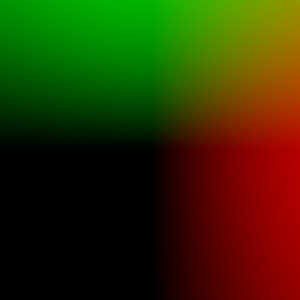

In [10]:
img = Image.merge("RGB", img_RGB)
display(img)

Das Bild zeigt die Richtungsvektoren der Rays.

Der x-Wert (Rot) steigt nach rechts an.
Der y-Wert (Grün) steigt nach oben an.
Der z-Wert ist 0 weil die Richtung jedes Rays in die negative Z-Richtung geht.-

In der Mitte des Bildes liegt der Nullpunkt von X und Y. Deshalb ist der linke untere Teil schwarz.